In [2]:
# --- Gerekli Kütüphaneler ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json # Sütun listesini kaydetmek için

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector

# Jupyter Notebook için ayarlar
%matplotlib inline
sns.set_style('darkgrid')

# --- 1. Veri Yükleme ve Sütun Adı Temizliği ---
print("1. Veri yükleniyor ve hazırlanıyor...")
file_path = '../data/raw/cic_ids_2017.csv'
try:
    df = pd.read_csv(file_path)
    
    # --- SÜTUN ADI STANDARTLAŞTIRMASI ---
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]', '', regex=True)
    
    print("   Sütun isimleri temizlendi ve standartlaştırıldı.")
    
    df['Label'] = df['Label'].apply(lambda x: 1 if x == 'DDoS' else 0)
    X = df.drop('Label', axis=1)
    y = df['Label']
    
    # --- YENİ ADIM: Sütun listesini API için kaydetme ---
    model_dir = '../app/models/'
    os.makedirs(model_dir, exist_ok=True)
    with open(os.path.join(model_dir, 'model_columns.json'), 'w') as f:
        json.dump(X.columns.tolist(), f)
    print("   Model sütunları 'app/models/model_columns.json' olarak kaydedildi.")
    
except FileNotFoundError:
    print(f"   HATA: Dosya bulunamadı: {file_path}")
    df = None

if df is not None:
    # --- 2. Veriyi Eğitim ve Test Olarak Ayırma ---
    print("\n2. Veri, eğitim ve test setlerine ayrılıyor...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # --- 3. Sonsuz Değerleri Temizleme ---
    print("\n3. Sonsuz (infinity) değerler temizleniyor...")
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    for col in X_train.select_dtypes(include=np.number).columns:
        if X_train[col].isnull().any():
            median_val = X_train[col].median()
            X_train[col] = X_train[col].fillna(median_val)
            X_test[col] = X_test[col].fillna(median_val)
    print("   Temizleme tamamlandı.")

    # --- 4. Sayısal Özellikleri Ölçeklendirme ---
    print("\n4. Sayısal özellikler ölçeklendiriliyor (StandardScaler)...")
    numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    scaler = StandardScaler()
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
    print("   Ölçeklendirme tamamlandı.")

1. Veri yükleniyor ve hazırlanıyor...
   Sütun isimleri temizlendi ve standartlaştırıldı.
   Model sütunları 'app/models/model_columns.json' olarak kaydedildi.

2. Veri, eğitim ve test setlerine ayrılıyor...

3. Sonsuz (infinity) değerler temizleniyor...
   Temizleme tamamlandı.

4. Sayısal özellikler ölçeklendiriliyor (StandardScaler)...
   Ölçeklendirme tamamlandı.



--- MODEL 1: ISOLATION FOREST ---
5. Isolation Forest modeli eğitiliyor...
   Model eğitimi tamamlandı.

6. Isolation Forest, test verisi üzerinde değerlendiriliyor...

--- Isolation Forest Sonuçları ---
Doğruluk Oranı (Accuracy): 0.3710

Sınıflandırma Raporu:
              precision    recall  f1-score   support

  BENIGN (0)       0.39      0.76      0.51     19544
    DDoS (1)       0.28      0.07      0.11     25605

    accuracy                           0.37     45149
   macro avg       0.33      0.42      0.31     45149
weighted avg       0.33      0.37      0.29     45149



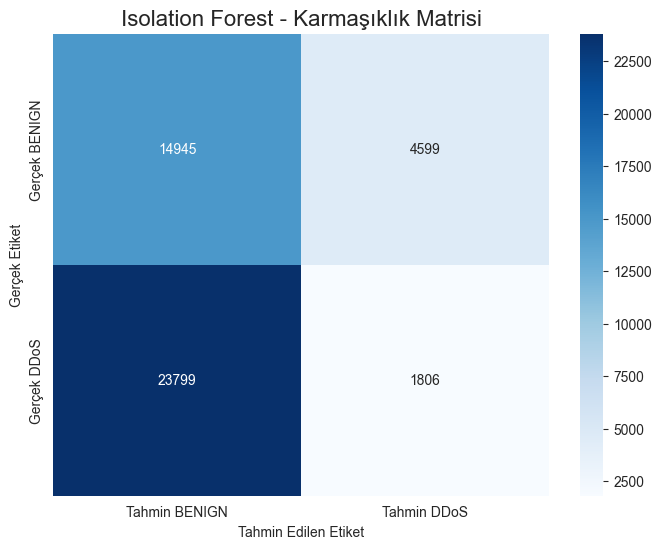

In [3]:
if 'X_train' in locals():
    print("\n--- MODEL 1: ISOLATION FOREST ---")
    print("5. Isolation Forest modeli eğitiliyor...")
    
    iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42, n_jobs=-1)
    iso_forest.fit(X_train)
    print("   Model eğitimi tamamlandı.")

    print("\n6. Isolation Forest, test verisi üzerinde değerlendiriliyor...")
    predictions = iso_forest.predict(X_test)
    y_pred_iso = [1 if pred == -1 else 0 for pred in predictions]

    print("\n--- Isolation Forest Sonuçları ---")
    print(f"Doğruluk Oranı (Accuracy): {accuracy_score(y_test, y_pred_iso):.4f}\n")
    print("Sınıflandırma Raporu:")
    print(classification_report(y_test, y_pred_iso, target_names=['BENIGN (0)', 'DDoS (1)']))
    
    cm_iso = confusion_matrix(y_test, y_pred_iso)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Tahmin BENIGN', 'Tahmin DDoS'], 
                yticklabels=['Gerçek BENIGN', 'Gerçek DDoS'])
    plt.title('Isolation Forest - Karmaşıklık Matrisi', fontsize=16)
    plt.ylabel('Gerçek Etiket')
    plt.xlabel('Tahmin Edilen Etiket')
    plt.show()

In [4]:
if 'X_train' in locals():
    print("\n--- MODEL 2: LSTM AUTOENCODER ---")
    print("7. LSTM Autoencoder için veri hazırlanıyor...")
    
    X_train_normal = X_train[y_train == 0]
    
    X_train_normal_3d = X_train_normal.values.reshape(X_train_normal.shape[0], 1, X_train_normal.shape[1])
    X_test_3d = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

    print("\n8. LSTM Autoencoder modeli oluşturuluyor...")
    timesteps = X_train_normal_3d.shape[1]
    n_features = X_train_normal_3d.shape[2]

    inputs = Input(shape=(timesteps, n_features))
    encoder = LSTM(64, activation='relu')(inputs)
    encoder = RepeatVector(timesteps)(encoder)
    decoder = LSTM(64, activation='relu', return_sequences=True)(encoder)
    decoder = LSTM(n_features, activation='linear', return_sequences=True)(decoder)
    
    autoencoder = Model(inputs=inputs, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mae')
    autoencoder.summary()


--- MODEL 2: LSTM AUTOENCODER ---
7. LSTM Autoencoder için veri hazırlanıyor...

8. LSTM Autoencoder modeli oluşturuluyor...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 78)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          36,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 78)               │          44,616 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 114,248 (446.28 KB)

 Trainable params: 114,248 (446.28 KB)

 Non-trainable params: 0 (0.00 B)


9. LSTM Autoencoder modeli eğitiliyor...
Epoch 1/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.2040 - val_loss: 0.0791
Epoch 2/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0702 - val_loss: 0.0499
Epoch 3/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0456 - val_loss: 0.0444
Epoch 4/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0403 - val_loss: 0.0376
Epoch 5/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0350 - val_loss: 0.0334
Epoch 6/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0317 - val_loss: 0.0315
Epoch 7/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0297 - val_loss: 0.0301
Epoch 8/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0291 - val_loss: 0.0290
Epoch 9/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0282 - val_loss: 0.0277
Epoch 10/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0262 - val_loss: 0.0234

10. Anomali eşiği (threshold) belirleniyor...
2443/2443 ━━━━━━━━━━━━━━━━━━━

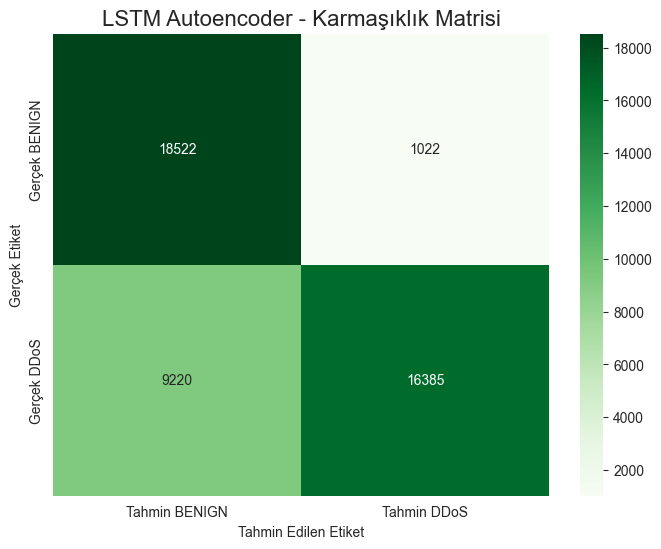

In [5]:
if 'autoencoder' in locals():
    print("\n9. LSTM Autoencoder modeli eğitiliyor...")
    
    history = autoencoder.fit(
        X_train_normal_3d, X_train_normal_3d,
        epochs=10, batch_size=64, validation_split=0.1, shuffle=True, verbose=1
    )

    print("\n10. Anomali eşiği (threshold) belirleniyor...")
    X_train_normal_pred_3d = autoencoder.predict(X_train_normal_3d)
    train_normal_mae_loss = np.mean(np.abs(X_train_normal_pred_3d - X_train_normal_3d), axis=(1, 2))
    threshold = np.percentile(train_normal_mae_loss, 95)
    print(f"   Belirlenen Anomali Eşiği: {threshold:.4f}")

    print("\n11. LSTM Autoencoder, test verisi üzerinde değerlendiriliyor...")
    X_test_pred_3d = autoencoder.predict(X_test_3d)
    test_mae_loss = np.mean(np.abs(X_test_pred_3d - X_test_3d), axis=(1, 2))
    y_pred_lstm = [1 if error > threshold else 0 for error in test_mae_loss]

    print("\n--- LSTM Autoencoder Sonuçları ---")
    print(f"Doğruluk Oranı (Accuracy): {accuracy_score(y_test, y_pred_lstm):.4f}\n")
    print("Sınıflandırma Raporu:")
    print(classification_report(y_test, y_pred_lstm, target_names=['BENIGN (0)', 'DDoS (1)']))

    cm_lstm = confusion_matrix(y_test, y_pred_lstm)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Tahmin BENIGN', 'Tahmin DDoS'],
                yticklabels=['Gerçek BENIGN', 'Gerçek DDoS'])
    plt.title('LSTM Autoencoder - Karmaşıklık Matrisi', fontsize=16)
    plt.ylabel('Gerçek Etiket')
    plt.xlabel('Tahmin Edilen Etiket')
    plt.show()

In [6]:
if 'iso_forest' in locals() and 'autoencoder' in locals() and 'scaler' in locals():
    print("\n12. Modeller ve diğer nesneler kaydediliyor...")
    
    model_dir = '../app/models/'
    
    joblib.dump(iso_forest, os.path.join(model_dir, 'isolation_forest.joblib'))
    print("   Isolation Forest modeli kaydedildi.")

    autoencoder.save(os.path.join(model_dir, 'lstm_autoencoder.keras'))
    print("   LSTM Autoencoder modeli kaydedildi.")

    joblib.dump(scaler, os.path.join(model_dir, 'scaler.joblib'))
    print("   StandardScaler kaydedildi.")
    
    with open(os.path.join(model_dir, 'lstm_threshold.txt'), 'w') as f:
        f.write(str(threshold))
    print("   LSTM anomali eşiği kaydedildi.")
    
    print("\nTüm nesneler başarıyla 'app/models/' klasörüne kaydedildi.")


12. Modeller ve diğer nesneler kaydediliyor...
   Isolation Forest modeli kaydedildi.
   LSTM Autoencoder modeli kaydedildi.
   StandardScaler kaydedildi.
   LSTM anomali eşiği kaydedildi.

Tüm nesneler başarıyla 'app/models/' klasörüne kaydedildi.
